# py_mpc.ipynb

## Lecture 10 of CMU16-745 (2025)
Created: Mar 11, 25


In [1]:
#!pip install osqp

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
#from numpy.linalg import solve
import scipy as sp
from scipy.sparse.linalg import  spsolve
from scipy.sparse import kron, block_diag, identity, hstack,vstack,lil_array,csc_array,dok_array
import osqp
import control as ctl

In [42]:
import warnings 
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
#Model parameters
g = 9.81 #m/s^2
m = 1.0 #kg 
l = 0.3 #meters
J = 0.2*m*l*l

#Thrust limits
umin = np.array([0.2*m*g, 0.2*m*g]).reshape(2,1)
umax = np.array([0.6*m*g, 0.6*m*g]).reshape(2,1)

h = 0.05 #time step (20 Hz)

In [4]:
#Planar Quadrotor Dynamics
def quad_dynamics(x,u):
    theta = x[2]

    xdd = ((1/m)*(u[0] + u[1])*np.sin(theta))
    #print(xdd)
    ydd = ((1/m)*(u[0] + u[1])*np.cos(theta) - g)
    #print(ydd)
    thetadd = ((1/J)*(l/2)*(u[1] - u[0]))
    #print(thetadd)
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    #x_result = np.array([x3,x4,x5, xdd, ydd, thetadd]).reshape(6,1)
    x_result = [x3,x4,x5,xdd,ydd,thetadd]
    
    return x_result

In [5]:
#  original. Does not work!
# def quad_dynamics_rk4(x,u):
#     #RK4 integration with zero-order hold on u
#     f1 = quad_dynamics(x, u)
#     f2 = quad_dynamics(x + 0.5*h*np.array(f1).reshape(6,1), u)
#     f3 = quad_dynamics(x + 0.5*h*np.array(f2).reshape(6,1), u)
#     f4 = quad_dynamics(x + h*np.array(f3).reshape(6,1), u)
#     return x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)

In [6]:
#   ------- modified ------------
def quad_dynamics_rk4(x,u):
    #RK4 integration with zero-order hold on u
    f1 = quad_dynamics(x, u)
    # print("============ x ============")
    # print(x)
    # print(x.shape)
    # print("=========== f1 ==========")
    # print(f1)

    f1a = [0.5*h*i for i in f1] # must do this for it to work

    # print("========== x+ f1a ==========")
    # print(x + f1a)

    f2 = quad_dynamics(x + f1a, u)
    # print("=========== f2 ==========")    
    # print(f2)
    f2a = [0.5*h*i for i in f2] # must do this for it to work
    f3 = quad_dynamics(x + f2a, u)
    # print("=========== f3 ==========")    
    # print(f3)    
    f3a = [0.5*h*i for i in f3] # must do this for it to work
    
    f4 = quad_dynamics(x + f3a, u)
    # print("=========== f4 ==========")    
    # print(f4)

    ft = f1a
    for i in range(len(ft)):
        ft[i] = x[i] + (h/6.0)*(f1[i] + 2*f2[i] + 2*f3[i] + f4[i])

    return ft

In [7]:
# wrapper to make PyDrake forwarddiff works
def quad_dynamics_rk4_x(x):
    global u_hover 
    return quad_dynamics_rk4(x, u_hover.flatten())

def quad_dynamics_rk4_u(u):
    global x_hover 
    return quad_dynamics_rk4(x_hover.flatten(), u)    
    

In [8]:
#Linearized dynamics for hovering
x_hover = np.zeros((6,1))
u_hover = np.array([[0.5*m*g],[ 0.5*m*g]])

In [9]:
u_hover

array([[4.905],
       [4.905]])

In [10]:
from pydrake import forwarddiff

In [11]:
A = forwarddiff.jacobian(quad_dynamics_rk4_x,x_hover.flatten())
A

array([[1.0000000e+00, 0.0000000e+00, 1.0218750e-02, 5.0000000e-02,
        0.0000000e+00, 1.5328125e-04],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        5.0000000e-02, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 5.0000000e-02],
       [0.0000000e+00, 0.0000000e+00, 4.9050000e-01, 1.0000000e+00,
        0.0000000e+00, 1.0218750e-02],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00]])

In [12]:
B = forwarddiff.jacobian(quad_dynamics_rk4_u,u_hover.flatten())
B

array([[-1.06445313e-05,  1.06445313e-05],
       [ 1.04166667e-03,  1.04166667e-03],
       [-8.68055556e-03,  8.68055556e-03],
       [-1.27734375e-03,  1.27734375e-03],
       [ 5.00000000e-02,  5.00000000e-02],
       [-4.16666667e-01,  4.16666667e-01]])

In [13]:
quad_dynamics_rk4(x_hover,u_hover)

[array([0.]), array([0.]), array([0.]), array([0.]), array([0.]), array([0.])]

In [14]:
Nx = 6     # number of state
Nu = 2     # number of controls
Tfinal = 10.0 # final time #try larger values
Nt = int(Tfinal/h)+1    # number of time steps
thist = np.arange(0,h*(Nt-1),h)

In [15]:
# Cost weights
Q = 1.0*np.eye(Nx)
R = 0.01*np.eye(Nu)
Qn = 1.0*np.eye(Nx)

In [16]:
def Cost(xhist, uhist):
    xend = xhist[:,-1]
    cost = 0.5*xend.T@Qn@xend
    for k in range(xhist.shape[1]-1):
        xk = xhist[:,k]
        uk = uhist[0,k]
        cost = cost + 0.5*xk.T@Q@xk + 0.5*uk*R*uk
    return cost

In [17]:
#LQR Hover Controller
P,_,_ = ctl.dare(A,B,Q,R)
K,_,_ = ctl.dlqr(A,B,Q,R)

def lqr_controller(t,x):
    global K, x_ref
    return u_hover - K@(x-x_ref)

In [18]:
K

array([[-1.01961303,  4.88080709, -6.425885  , -1.5454789 ,  5.3779013 ,
        -1.351607  ],
       [ 1.01961303,  4.88080709,  6.425885  ,  1.5454789 ,  5.3779013 ,
         1.351607  ]])

In [19]:
P

array([[ 3.03150087e+01,  3.44875926e-14,  2.39223482e+01,
         1.22171187e+01,  3.77642597e-15,  6.40307274e-01],
       [ 3.44875926e-14,  2.20369345e+01,  7.75161653e-15,
         2.34595678e-14,  1.58973867e+00, -3.84157297e-16],
       [ 2.39223482e+01,  7.75161653e-15,  1.31430548e+02,
         3.48838584e+01,  3.41840948e-14,  3.71339865e+00],
       [ 1.22171187e+01,  2.34595678e-14,  3.48838584e+01,
         1.61398694e+01,  7.57864774e-15,  9.48528786e-01],
       [ 3.77642597e-15,  1.58973867e+00,  3.41840948e-14,
         7.57864774e-15,  2.12194764e+00,  9.49740729e-16],
       [ 6.40307274e-01, -3.84157297e-16,  3.71339865e+00,
         9.48528786e-01,  9.49740729e-16,  1.13408104e+00]])

In [55]:
# Build QP matrices for OSQP
Nh = 20 # one second horizon at 20 Hz
#Nx = 6  # Nx, Nu defined above
#Nu = 2
U = kron(identity(Nh),hstack((identity(Nu),lil_array(np.zeros((Nu,Nx)))))) # matrix that picks out all u
#U = csc_array(U)
T = kron(identity(Nh),np.array([0,0,0,0,1,0,0,0])) # matrix that picsks out all x3 (theta)
#T = csc_array(T)
H_12 = vstack((hstack((R,lil_array(np.zeros((Nu,Nx))))),
        hstack((lil_array(np.zeros((Nx,Nu))),Q))))
H_11 = kron(identity(Nh-1),H_12)
H_13 = lil_array(np.zeros(((Nx+Nu)*(Nh-1),Nx+Nu)))
H_1 = hstack((H_11,H_13))

# H_1 = hstack((kron(identity(Nh-1), vstack((hstack((R,lil_array(np.zeros((Nu,Nx))))),
#         hstack((lil_array(np.zeros((Nx,Nu))),Q)))))
#               ,lil_array(np.zeros(((Nx+Nu)*(Nh-1),Nx+Nu)))))
H_3 = lil_array(np.zeros((Nx+Nu,(Nx+Nu)*(Nh-1))))
H_4 = vstack((hstack((R,lil_array((np.zeros((Nu,Nx)))))),hstack((lil_array(np.zeros((Nx,Nu))),P))))
H_2 = hstack((H_3,H_4))
H = vstack((H_1,H_2))
#H = csc_array(H)

b = np.zeros((Nh*(Nx+Nu),1))

C_1 = hstack((B, -identity(Nx), lil_array(np.zeros((Nx,(Nh-1)*(Nu+Nx))))))
C_5 = hstack((kron(identity(Nh-1),hstack((lil_array(A),lil_array(B)))), lil_array(np.zeros(((Nh-1)*Nx,Nx)))))

C_6 = hstack((lil_array(np.zeros(((Nh-1)*Nx,Nx))), 
              kron(identity(Nh-1),hstack((lil_array(np.zeros((Nx,Nu))),-identity(Nx))))))
C_4 = hstack((lil_array(np.zeros((Nx*(Nh-1),Nu))),C_5+C_6))
C = vstack((C_1,C_4))
#C = csc_array(C)

# Dynamics + Thrust limit constraints
D = vstack((C,U))
lb = vstack((lil_array(np.zeros((Nx*Nh,1))),kron(lil_array(np.ones((Nh,1))),umin - u_hover)))
ub = vstack((lil_array(np.zeros((Nx*Nh,1))),kron(lil_array(np.ones((Nh,1))),umax - u_hover)))              

#Dynamics + thrust limit + bound constraint on θ to keep the system within small-angle approximation
# D = vstack((C,U,T))
# lb = vstack((lil_array(np.zeros((Nx*Nh,1))),
#              kron(lil_array(np.ones((Nh,1))),umin - u_hover),-0.2*lil_array(np.ones((Nh,1)))))
# ub = vstack((lil_array(np.zeros((Nx*Nh,1))),
#              kron(lil_array(np.ones((Nh,1))),umax - u_hover),0.2*lil_array(np.ones((Nh,1)))))     

lb = dok_array(lb)
ub = dok_array(ub)
prob = osqp.OSQP()
prob.setup(P=H,q=b,A=D,l=lb.toarray(),u=ub.toarray(),verbose=False,eps_abs=1e-8,eps_rel=1e-8,polish=1)


In [21]:
# MPC Controller
def mpc_controller(t,x):
    global x_ref, lb, ub, b
    # Update QP problem
    lb[0:6,[0]] = -A@x
    ub[0:6,[0]] = -A@x
    # print("lb[0:6,[0]] = ")
    # print(lb[0:6,[0]])
    # print("ub[0:6,[0]]")
    # print(ub[0:6,[0]])
    for j in range(Nh-1):
        idx = Nu+j*(Nx+Nu)
        b[idx:Nx+idx,[0]] = -Q@x_ref
    idx = Nu+(Nh-1)*(Nx+Nu)
    b[idx:Nx+idx,[0]] = -P@x_ref
    # print("b = ")
    # print(b)
    # print("b shape = ")
    # print(b.shape)
    prob.update(q=b, l=lb.toarray(), u=ub.toarray())
    results = prob.solve()
    # print(results.x)
    du = results.x[0:Nu].reshape(2,1)
    return u_hover + du
    
    



In [22]:
def closed_loop(x0, controller, N):
    xhist = np.zeros((len(x0),N))
    u0 = controller(0,x0)
    uhist = np.zeros((len(u0),N-1))
    uhist[:,[0]] = u0
    xhist[:,[0]] = x0
    for k in range(N-1):
        uk = controller(k,xhist[:,[k]])
        uhist[:,[k]] = np.maximum(np.minimum(umax, uk), umin) # enforce control limits
        xhist[:,[k+1]] = quad_dynamics_rk4(xhist[:,[k]], uhist[:,[k]])
    return xhist, uhist

In [56]:
x_ref = np.array([0.0,1.0,0.,0.,0.,0.]).reshape(6,1)
x0 = np.array([10.,2.,0.,0.,0.,0.]).reshape(6,1)
xhist1, uhist1 = closed_loop(x0,lqr_controller, Nt)
xhist2, uhist2 = closed_loop(x0, mpc_controller, Nt)

In [24]:
# comparison plot
def compare(t,v1, v2, label):
    plt.figure()
    plt.plot(t,v1,"m-",t,v2,"g-")
    plt.xlabel("time (sec)")
    plt.ylabel(label)
    plt.legend([label+" LQR",label+" MPC"])
    plt.grid(True)
    plt.show()   

In [48]:
mpld3.disable_notebook()  # must use this to get rid of matplotlib warning. Then enable it in Drake simulation.

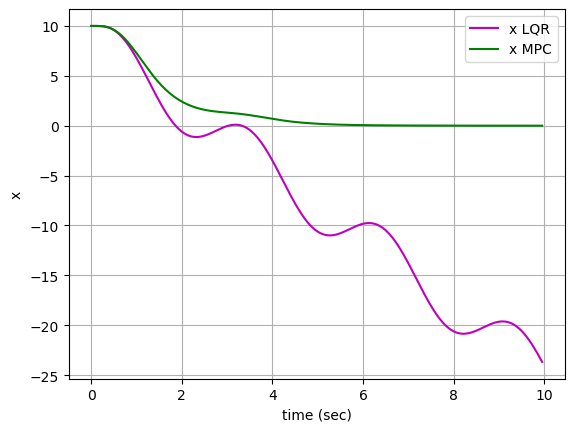

In [57]:
compare(thist,xhist1[0,:-1],xhist2[0,:-1],"x")

In [58]:
compare(thist,xhist1[1,:-1],xhist2[1,:-1],"y")

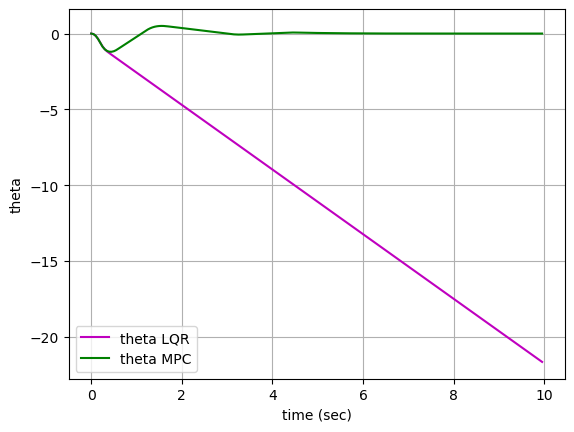

In [59]:
compare(thist,xhist1[2,:-1],xhist2[2,:-1],"theta")

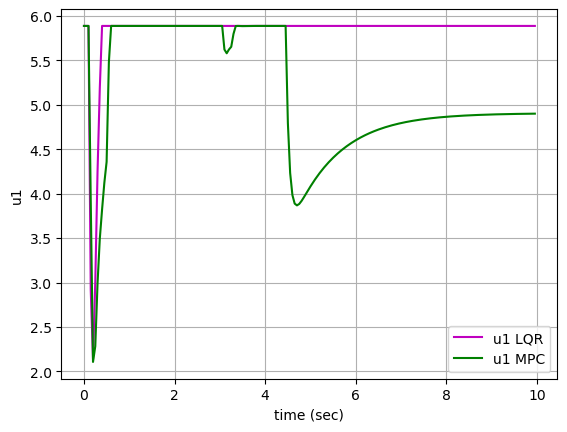

In [60]:
compare(thist,uhist1[0,:],uhist2[0,:],"u1")

In [61]:
compare(thist,uhist1[1,:],uhist2[1,:],"u2")

### planar quadrotor simulation

Use Drake and meshcat to simulate the drone.

Below is the source code of quadrotor2d.py from underactuated. We need to adjust 
quadrotor parameters to match ours.

In [75]:
import numpy as np
from pydrake.systems.framework import LeafSystem_, PortDataType
from pydrake.systems.pyplot_visualizer import PyPlotVisualizer
from pydrake.systems.scalar_conversion import TemplateSystem

# Note: In order to use the Python system with drake's autodiff features, we
# have to add a little "TemplateSystem" boilerplate (for now).  For details,
# see https://drake.mit.edu/pydrake/pydrake.systems.scalar_conversion.html


@TemplateSystem.define("Quadrotor2D_")
def Quadrotor2D_(T):
    class Impl(LeafSystem_[T]):
        def _construct(self, converter=None):
            LeafSystem_[T].__init__(self, converter)
            # control input (thrust)
            self.DeclareVectorInputPort("u", 2)
            # disturbance input (e.g. a cartesian force from "wind")
            self.DeclareVectorInputPort("w", 2)
            # three positions, three velocities
            state_index = self.DeclareContinuousState(3, 3, 0)
            # six outputs (full state)
            self.DeclareStateOutputPort("x", state_index)

            # parameters from Lecture 10 of CMU16-745 
            self.length = 0.3  # length of rotor arm
            self.mass = 1.0  # mass of quadrotor
            self.inertia = 0.2*self.mass*self.length*self.length  # moment of inertia
            self.gravity = 9.81  # gravity
            
            # parameters based on [Bouadi, Bouchoucha, Tadjine, 2007]
            # self.length = 0.25  # length of rotor arm
            # self.mass = 0.486  # mass of quadrotor
            # self.inertia = 0.00383  # moment of inertia
            # self.gravity = 9.81  # gravity
            self.set_name("Quadrotor2D")

        def _construct_copy(self, other, converter=None):
            Impl._construct(self, converter=converter)

        def DoCalcTimeDerivatives(self, context, derivatives):
            x = context.get_continuous_state_vector().CopyToVector()
            u = self.EvalVectorInput(context, 0).CopyToVector()
            w = (
                self.EvalVectorInput(context, 1).CopyToVector()
                if self.get_input_port(1).HasValue(context)
                else [0, 0]
            )
            q = x[:3]
            qdot = x[3:]
            qddot = np.array(
                [
                    # changed according to lecture 10 data
                    (w[0] + (u[0] + u[1]) * np.sin(q[2])) / self.mass,
                    (w[1] + (u[0] + u[1]) * np.cos(q[2])) / self.mass - self.gravity,
                    self.length * (u[1] - u[0]) / (2*self.inertia),                    
                ]
            )
            # -- original code ---
            # qddot = np.array(
            #     [
            #         (w[0] - (u[0] + u[1]) * np.sin(q[2])) / self.mass,
            #         (w[1] + (u[0] + u[1]) * np.cos(x[2])) / self.mass - self.gravity,
            #         self.length * (u[0] - u[1]) / self.inertia,
            #     ]
            # )

            
            derivatives.get_mutable_vector().SetFromVector(
                np.concatenate((qdot, qddot))
            )

    return Impl


Quadrotor2D = Quadrotor2D_[None]  # Default instantiation


class Quadrotor2DVisualizer(PyPlotVisualizer):
    def __init__(self, ax=None, show=None):
        PyPlotVisualizer.__init__(self, ax=ax, show=show)
        self.DeclareInputPort("state", PortDataType.kVectorValued, 6)
        self.ax.set_aspect("auto")
        
        self.ax.set_xlim(-1, 12)
        #self.ax.set_xticks(np.arange(-5,10,1))
        self.ax.set_ylim(-2.5,2.5)
        self.ax.scatter(0.0,1.0,marker='x') # add reference
        self.ax.plot([-5,10],[0,0],'b-')  # add floor level

        self.length = 0.3  # changed 0.25  # moment arm (meters)

        self.base = np.vstack(
            (
                1.2 * self.length * np.array([1, -1, -1, 1, 1]),
                0.025 * np.array([1, 1, -1, -1, 1]),
            )
        )
        self.pin = np.vstack(
            (
                0.005 * np.array([1, 1, -1, -1, 1]),
                0.1 * np.array([1, 0, 0, 1, 1]),
            )
        )
        a = np.linspace(0, 2 * np.pi, 50)
        self.prop = np.vstack(
            (self.length / 1.5 * np.cos(a), 0.1 + 0.02 * np.sin(2 * a))
        )

        # yapf: disable
        self.base_fill = self.ax.fill(
            self.base[0, :], self.base[1, :], zorder=1, edgecolor="k",
            facecolor=[.6, .6, .6])
        self.left_pin_fill = self.ax.fill(
            self.pin[0, :], self.pin[1, :], zorder=0, edgecolor="k",
            facecolor=[0, 0, 0])
        self.right_pin_fill = self.ax.fill(
            self.pin[0, :], self.pin[1, :], zorder=0, edgecolor="k",
            facecolor=[0, 0, 0])
        self.left_prop_fill = self.ax.fill(
            self.prop[0, :], self.prop[0, :], zorder=0, edgecolor="k",
            facecolor=[0, 0, 1])
        self.right_prop_fill = self.ax.fill(
            self.prop[0, :], self.prop[0, :], zorder=0, edgecolor="k",
            facecolor=[0, 0, 1])
        # yapf: enable

    def draw(self, context):
        x = self.EvalVectorInput(context, 0).CopyToVector()
        R = np.array([[np.cos(x[2]), -np.sin(x[2])], [np.sin(x[2]), np.cos(x[2])]])

        p = np.dot(R, self.base)
        self.base_fill[0].get_path().vertices[:, 0] = x[0] + p[0, :]
        self.base_fill[0].get_path().vertices[:, 1] = x[1] + p[1, :]

        p = np.dot(R, np.vstack((-self.length + self.pin[0, :], self.pin[1, :])))
        self.left_pin_fill[0].get_path().vertices[:, 0] = x[0] + p[0, :]
        self.left_pin_fill[0].get_path().vertices[:, 1] = x[1] + p[1, :]
        p = np.dot(R, np.vstack((self.length + self.pin[0, :], self.pin[1, :])))
        self.right_pin_fill[0].get_path().vertices[:, 0] = x[0] + p[0, :]
        self.right_pin_fill[0].get_path().vertices[:, 1] = x[1] + p[1, :]

        p = np.dot(R, np.vstack((-self.length + self.prop[0, :], self.prop[1, :])))
        self.left_prop_fill[0].get_path().vertices[:, 0] = x[0] + p[0, :]
        self.left_prop_fill[0].get_path().vertices[:, 1] = x[1] + p[1, :]

        p = np.dot(R, np.vstack((self.length + self.prop[0, :], self.prop[1, :])))
        self.right_prop_fill[0].get_path().vertices[:, 0] = x[0] + p[0, :]
        self.right_prop_fill[0].get_path().vertices[:, 1] = x[1] + p[1, :]
        
        self.ax.set_title("t = {:.1f}".format(context.get_time()))


In [65]:
import mpld3
import numpy as np
from IPython.display import HTML, display
#from pydrake.all import DiagramBuilder, LinearQuadraticRegulator, Simulator
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder, BasicVector, LeafSystem
from pydrake.systems.primitives import ConstantVectorSource

from underactuated import running_as_notebook
#from underactuated.quadrotor2d import Quadrotor2D, Quadrotor2DVisualizer



In [34]:
# create control output to drive the quadrotor
class control_traj(LeafSystem):
    def __init__(self, uhist, Ts):
        super().__init__()
        self.uhist = uhist  # control history vector
        self.Nt = uhist.shape[1] 
        self.Ts = Ts
        self.i = 0  # time index
        num_input = 1  # actually, input is not needed 
        num_output = uhist.shape[0]

        self.DeclareDiscreteState(num_output)  # state = output
        self.r = self.DeclareVectorInputPort("r", BasicVector(num_input))  
        self.DeclareVectorOutputPort("u", BasicVector(num_output), 
                            self.CalcU, set([self.all_state_ticket()])) # last argument required to avoid
                                                                            # algebraic loop
        self.DeclarePeriodicDiscreteUpdateEvent(
            period_sec=self.Ts,  # sampling time
            offset_sec=0.0,  # The first event is at time zero.
            update=self.Update) # Call the Update method defined below.
    def Update(self, context, discrete_state):
        x = context.get_discrete_state_vector().CopyToVector()
        r = self.r.Eval(context) # not used
        xnext = self.uhist[:,self.i]
        if self.i < self.Nt:
            self.i+=1
        
        discrete_state.get_mutable_vector().SetFromVector(xnext)

    def CalcU(self, context, output):
        u = context.get_discrete_state_vector().CopyToVector()
        output.SetFromVector(u)
        

In [35]:
# simulate planar quadrotor from control vector 
def Quad2Dsim(uhist):
    builder = DiagramBuilder()
    quad2d = builder.AddSystem(Quadrotor2D())
    u = builder.AddSystem(control_traj(uhist,h))
    builder.Connect(u.get_output_port(),quad2d.get_input_port(0))
    stepInput = builder.AddSystem(ConstantVectorSource([1]))  # step-input. Not used
    builder.Connect(stepInput.get_output_port(0), u.get_input_port())     
    # Setup visualization
    visualizer = builder.AddSystem(Quadrotor2DVisualizer(show=False))
    builder.Connect(quad2d.get_output_port(0), visualizer.get_input_port(0))

    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    duration = 10.0 if running_as_notebook else 0.1
    visualizer.start_recording()
    print("simulating...")
    context.SetTime(0.0) 
    context.SetContinuousState(x0)
    simulator.Initialize()
    simulator.AdvanceTo(duration)
    print("done.\ngenerating animation...")
    ani = visualizer.get_recording_as_animation()
    display(HTML(ani.to_jshtml()))    
    
    

In [ ]:
if running_as_notebook:  # this does not seem necessary
    mpld3.enable_notebook()

In [76]:
Quad2Dsim(uhist1) # LQR

simulating...
done.
generating animation...


In [77]:
Quad2Dsim(uhist2) # MPC

simulating...
done.
generating animation...
